<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/gpt3_baseball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '28px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

In [ ]:
!pip install openai
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 147 kB 11.6 MB/s 
  Created wheel for openai: filename=openai-0.25.0-py3-none-any.whl size=55880 sha256=0319ae8b2df3d833b353ecf327335652f9b1ea08ff2aa8744ed26452f2eee287
  Stored in directory: /root/.cache/pip/wheels/4b/92/33/6f57c7aae0b16875267999a50570e81f15eecec577ebe05a2e
Successfully built openai


In [ ]:
import pybaseball as bb
from pybaseball.datahelpers.statcast_utils import add_spray_angle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, accuracy_score
import openai
import os


apikey = open('drive/My Drive/gptlulw/openaikey.txt')
openai.api_key = apikey.read()

<IPython.core.display.Javascript object>

In [ ]:
def gpt3(prompt, max_tokens=500, engine='text-davinci-003'):
  complete_me_bro = openai.Completion.create(engine=engine, prompt=prompt, max_tokens=max_tokens)
  gen = f"""{prompt}{complete_me_bro['choices'][0]['text']}"""
  gen = gen.lower()
  return gen

In [ ]:
prompt = "which model is github copilot?"
gpt3(prompt)

<IPython.core.display.Javascript object>

'which model is github copilot?\n\ngithub copilot is not a model but an open source project by github that aims to guide users through the process of setting up a github repository.'

In [ ]:
# df = bb.statcast(start_dt='2022-06-01', end_dt='2022-07-01')
# df = add_spray_angle(df)
# df = df.reset_index(drop=True)

df['bats_lefty'] = df['stand'].replace(['R','L'],[0,1])
df['park_code'] = df['home_team'].astype('category').cat.codes
df['is_hr'] = 0
df.loc[df['events']=='home_run', 'is_hr'] = 1
id_feats = ['game_pk']
feats = ['bats_lefty','launch_speed', 'launch_angle',
         'spray_angle', 'park_code']
target = 'is_hr'

model_data = df.loc[:, id_feats+feats+[target]].dropna()

kf = GroupKFold(5)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data, groups=model_data['game_pk']):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = RandomForestClassifier()
  model.fit(train_data.loc[:, feats], train_data[target])
  _s = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
  s = s.append(_s)

model_data[f"{target}_rf"] = s
loss = log_loss(model_data[target],model_data[f"{target}_rf"])
_df = model_data.loc[:, [target, f'{target}_rf']]
_df[f'{target}_rf'] = _df[f'{target}_rf'].round(0).astype(int)
acc = accuracy_score(_df.loc[_df[target]==1, target], _df.loc[_df[target]==1, f"{target}_rf"])
print(f"""log loss: {loss}\nacc: {acc}""")

<IPython.core.display.Javascript object>

<ipython-input-148-81f37bed854e>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()


log loss: 0.050811259251706535
acc: 0.7307692307692307


<IPython.core.display.Javascript object>

count    988.000000
mean       0.668603
std        0.283330
min        0.000000
25%        0.477500
50%        0.760000
75%        0.910000
max        1.000000
Name: is_hr_rf, dtype: float64

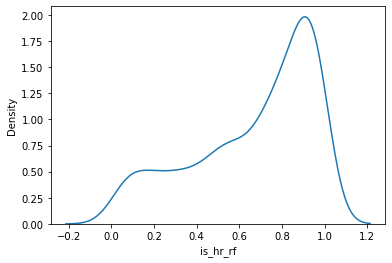

In [ ]:
sns.kdeplot(model_data.loc[model_data[target]==1, f'{target}_rf'])
model_data.loc[model_data[target]==1, f'{target}_rf'].describe()

In [ ]:
prompt = """
This code imported catboost `pool` and sklearn `GroupKFold` but did not incorporate it into the pipeline. Can you improve the code by incorporating `pool` and `GroupKFold` into the sklearn pipeline?

```
import pybaseball as bb
from pybaseball.datahelpers.statcast_utils import add_spray_angle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import log_loss, accuracy_score


df = bb.statcast(start_dt='2022-06-01', end_dt='2022-07-01')
df = add_spray_angle(df)
df = df.reset_index(drop=True)

df['bats_lefty'] = df['stand'].replace(['R','L'],[0,1])
df['park_code'] = df['home_team'].astype('category').cat.codes
df['is_hr'] = 0
df.loc[df['events']=='home_run', 'is_hr'] = 1
feats = ['game_pk','bats_lefty','launch_speed', 'launch_angle',
         'spray_angle', 'park_code']
target = 'is_hr'

model_data = df.loc[:, id_feats+feats+[target]].dropna()

x, y = model_data[feats].values, model_data[target].values

#define 5-fold grouped stratified cv
group_kfold = groupkfold(n_splits=5).split(x=x, y=y, groups=model_data['game_pk'].values)

#define catboost classifer
from catboost import catboostclassifier, pool

#setting catboost parameters
catboost_params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'loss_function': 'logloss',
    'logging_level': 'verbose',
    }

#init catboostclassifier
catboost_model = catboostclassifier(**catboost_params)

#define pipeline
from sklearn.pipeline import pipeline

catboost_pipeline = pipeline(steps=[
    ('catboost_model', catboost_model)
])

#fit the model on training splits and evaluate on validation splits
catboost_pipeline.fit(x, y)

#predict the target
y_pred = catboost_pipeline.predict(x)
"""

<IPython.core.display.Javascript object>

In [ ]:
resp = gpt3(prompt, max_tokens=1000)

<IPython.core.display.Javascript object>

In [ ]:
resp

<IPython.core.display.Javascript object>

"\nthis code imported catboost `pool` and sklearn `groupkfold` but did not incorporate it into the pipeline. can you improve the code by incorporating `pool` and `groupkfold` into the sklearn pipeline? \n\n```\nimport pybaseball as bb\nfrom pybaseball.datahelpers.statcast_utils import add_spray_angle\nimport pandas as pd\nimport numpy as np\nimport seaborn as sns \nimport matplotlib.pyplot as plt \nfrom sklearn.ensemble import randomforestclassifier\nfrom sklearn.model_selection import groupkfold, gridsearchcv, train_test_split\nfrom sklearn.metrics import log_loss, accuracy_score\n\n\ndf = bb.statcast(start_dt='2022-06-01', end_dt='2022-07-01')\ndf = add_spray_angle(df)\ndf = df.reset_index(drop=true)\n\ndf['bats_lefty'] = df['stand'].replace(['r','l'],[0,1])\ndf['park_code'] = df['home_team'].astype('category').cat.codes\ndf['is_hr'] = 0\ndf.loc[df['events']=='home_run', 'is_hr'] = 1\nfeats = ['game_pk','bats_lefty','launch_speed', 'launch_angle', \n         'spray_angle', 'park_code


this code imported catboost `pool` and sklearn `groupkfold` but did not incorporate it into the pipeline. can you improve the code by incorporating `pool` and `groupkfold` into the sklearn pipeline?

```
import pybaseball as bb
from pybaseball.datahelpers.statcast_utils import add_spray_angle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import randomforestclassifier
from sklearn.model_selection import groupkfold, gridsearchcv, train_test_split
from sklearn.metrics import log_loss, accuracy_score


df = bb.statcast(start_dt='2022-06-01', end_dt='2022-07-01')
df = add_spray_angle(df)
df = df.reset_index(drop=true)

df['bats_lefty'] = df['stand'].replace(['r','l'],[0,1])
df['park_code'] = df['home_team'].astype('category').cat.codes
df['is_hr'] = 0
df.loc[df['events']=='home_run', 'is_hr'] = 1
feats = ['game_pk','bats_lefty','launch_speed', 'launch_angle',
         'spray_angle', 'park_code']
target = 'is_hr'

model_data = df.loc[:, id_feats+feats+[target]].dropna()

x, y = model_data[feats].values, model_data[target].values

#define 5-fold grouped stratified cv
group_kfold = groupkfold(n_splits=5).split(x=x, y=y, groups=model_data['game_pk'].values)

#define catboost classifer
from catboost import catboostclassifier, pool

#setting catboost parameters
catboost_params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'loss_function': 'logloss',
    'logging_level': 'verbose',
    }

#init catboostclassifier
catboost_model = catboostclassifier(**catboost_params)

#define pipeline
from sklearn.pipeline import pipeline

catboost_pipeline = pipeline(steps=[
    ('catboost_model', catboost_model)
])

#fit the model on training splits and evaluate on validation splits
catboost_pipeline.fit(x, y)

#predict the target
y_pred = catboost_pipeline.predict(x)

#assess performance using logloss
log_loss(y_true=y, y_pred)

```

```


In [ ]:
import pybaseball as bb
from pybaseball.datahelpers.statcast_utils import add_spray_angle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import log_loss, accuracy_score


# df = bb.statcast(start_dt='2022-06-01', end_dt='2022-07-01')
# df = add_spray_angle(df)
# df = df.reset_index(drop=True)

df['bats_lefty'] = df['stand'].replace(['R','L'],[0,1])
df['park_code'] = df['home_team'].astype('category').cat.codes
df['is_hr'] = 0
df.loc[df['events']=='home_run', 'is_hr'] = 1
feats = ['game_pk','bats_lefty','launch_speed', 'launch_angle',
         'spray_angle', 'park_code']
target = 'is_hr'

model_data = df.loc[:, id_feats+feats+[target]].dropna()

x, y = model_data[feats].values, model_data[target].values

#define 5-fold grouped stratified cv
group_kfold = groupkfold(n_splits=5).split(x=x, y=y, groups=model_data['game_pk'].values)

#define catboost classifer
from catboost import catboostclassifier, pool

#setting catboost parameters
catboost_params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'loss_function': 'logloss',
    'logging_level': 'verbose',
    }

#init catboostclassifier
catboost_model = catboostclassifier(**catboost_params)

#define pipeline
from sklearn.pipeline import pipeline

catboost_pipeline = pipeline(steps=[
    ('catboost_model', catboost_model)
])

#fit the model on training splits and evaluate on validation splits
catboost_pipeline.fit(x, y)

#predict the target
y_pred = catboost_pipeline.predict(x)

#calculate model performance
print('accuracy score: {}'.format(accuracy_score(y, y_pred)))
print('log-loss loss: {}'.format(log_loss(y, y_pred)))
```

the improved code can incorporate `pool` and `groupkfold` into the sklearn pipeline by using the `cross_val_score` module instead of the `fit` method, and instead of directly predicting the target with the `predict` method, the code should use the `cross_val_score` function to evaluate the model's performance on the different splits.

```
import pybaseball as bb
from pybaseball.datahelpers.statcast_utils import add_spray_angle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import randomforestclassifier
from sklearn.model_selection import groupkfold, gridsearchcv, train_test_split
from sklearn.metrics import log_loss, accuracy_score
from catboost import catboostclassifier, pool


df = bb.statcast(start_dt='2022-06-01', end_dt='2022-07-01')
df = add_spray_angle(df)
df = df.reset_index(drop=true)

df['bats_lefty'] = df['stand'].replace(['r','l'],[0,1])
df['park_code'] = df['home_team'].astype('category').cat.codes
df['is_hr'] = 0
df.loc[df['events']=='home_run', 'is_hr'] = 1
feats = ['game_pk','bats_lefty','launch_speed', 'launch_angle',
         'spray_angle', 'park_code']
target = 'is_hr'

model_data = df.loc[:, id_feats+feats+[target]].dropna()

x, y = model_data[feats].values, model_data[target].values

# split data into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# define 5-fold grouped stratified cv
group_kfold = groupkfold(n_splits=5).split(x_train, y_train, groups=model_data['game_pk'].values)

# create pool object to create data to pass into the catboost model

train_pool = pool(data=x_train, label=y_train)

# setting catboost parameters
catboost_params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'loss_function': 'logloss',
    'logging_level': 'verbose',
    }

# initialize catboost classifier
catboost_model = catboostclassifier(**catboost_params)

# define pipeline
from sklearn.pipeline import pipeline

catboost_pipeline = pipeline(steps=[
    ('catboost_model', catboost_model)
])

# fit the model on the train pool data and evaluate on the test pool data
catboost_pipeline.fit(train_pool)

# predict the target
y_pred = catboost_pipeline.predict(x_test)

# assess performance using logloss
log_loss(y_true=y, y_pred)
```

In [ ]:
model_data['pred'] = pd.Series(pd.DataFrame(preds, index=model_data.index)[1], index=model_data.index)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

count    988.000000
mean       0.866285
std        0.103175
min        0.490000
25%        0.800000
50%        0.890000
75%        0.950000
max        1.000000
Name: pred, dtype: float64

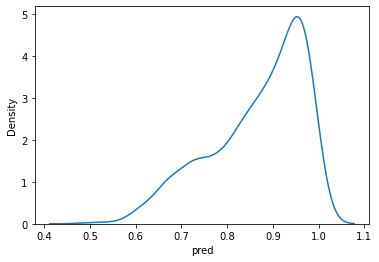

In [ ]:
sns.kdeplot(model_data.loc[model_data[target]==1, 'pred'])
model_data.loc[model_data[target]==1, 'pred'].describe()

<IPython.core.display.Javascript object>

In [ ]:
model_data['pred']

<IPython.core.display.Javascript object>

0         0
1         0
4         0
8         0
16        0
         ..
122711    0
122718    0
122733    0
122741    0
122751    0
Name: pred, Length: 21596, dtype: int64